# Analysis of HistNN and CNN

We look at the histogram representation and the intermediate (after first convolution) representation of a CNN to better understand the strengths of each approach.

In [1]:
import sys
import copy
import theano
sys.path.append('..')
import numpy as np
import agronn.dataio as dataio
import agronn.utils as utils
import agronn.colormaps as colormaps
import agronn.keras_utils as keras_utils
import matplotlib.cm as cm
import seaborn as sns
import sklearn.metrics as skmetrics
import agronn.my_ops as my_ops
import pylab as pl
import agronn.colormaps
%matplotlib inline

np.set_printoptions(precision=5, suppress=True)

Using gpu device 0: Tesla M2075 (CNMeM is disabled)


## Load data

In [2]:
expname = 'labels_4_test_fold_0_rep_0'
mosaic, id2label, train_ij, test_ij, y_train, y_test, _d = dataio.load(
    expname, ret_d=True, data_fname='../data_rot90_final.hdf5')
padded_shape = _d['padded_shape']
rot_angles = _d['rot_angles']

In [3]:
print padded_shape
print mosaic.shape

[3431 3431    3]
(13724, 3431, 3)


## Load model

In [4]:
import os

model_mnn = keras_utils.load_model(
    os.path.join('..', '..',
        'results/rot90_final/labels_4_test_fold_0_rep_0_gpu0_2015_11_16_10_16_06_epochs_60_60_60/merged_nn.zip'),
    mosaic.astype(np.float32)
)
model_cnn = keras_utils.load_model(
    os.path.join('..', '..',
        'results/rot90_final/labels_4_test_fold_0_rep_0_gpu0_2015_11_16_10_16_06_epochs_60_60_60//cnn.zip'),
    mosaic.astype(np.float32)
)
model_hnn = keras_utils.load_model(
    os.path.join('..', '..',
        'results/rot90_final/labels_4_test_fold_0_rep_0_gpu0_2015_11_16_10_16_06_epochs_60_60_60//histnn.zip'),
    mosaic.astype(np.float32)
)

In [5]:
# Compile some theano functions to get intermediate results
winl = model_mnn.nodes['extract_windows']
get_win = theano.function(
    [model_mnn.get_input()],
    winl.get_output(train=False)
)

histl = model_hnn.nodes['histnn'].nodes['extract_hist']
get_hist = theano.function(
    [model_hnn.get_input()],
    histl.get_output(train=False)
)

convl = model_cnn.nodes['cnn'].nodes['act1']
apply_conv = theano.function(
    [model_cnn.get_input()],
    convl.get_output(train=False),
)

get_pred_hnn = theano.function(
    [model_hnn.get_input()],
    model_hnn.get_output(train=False)
)

get_pred_cnn = theano.function(
    [model_cnn.get_input()],
    model_cnn.get_output(train=False)
)

get_pred_mnn = theano.function(
    [model_mnn.get_input()],
    model_mnn.get_output(train=False)
)

# This is how you use it
input_ij = np.vstack(([2520, 1300], [3000, 2000])).astype(np.float32)
convout = apply_conv(input_ij)
winout = get_win(input_ij)
histout = get_hist(input_ij)
print input_ij
print input_ij.shape
print convout.shape
print winout.shape
print histout.shape

[[ 2520.  1300.]
 [ 3000.  2000.]]
(2, 2)
(2, 48, 11, 11)
(2, 3, 21, 21)
(2, 3, 20)


In [6]:
y_test_pred_hnn = np.argmax(get_pred_hnn(test_ij), axis=1)
y_test_pred_cnn = np.argmax(get_pred_cnn(test_ij), axis=1)
y_test_pred_mnn = np.argmax(get_pred_mnn(test_ij), axis=1)

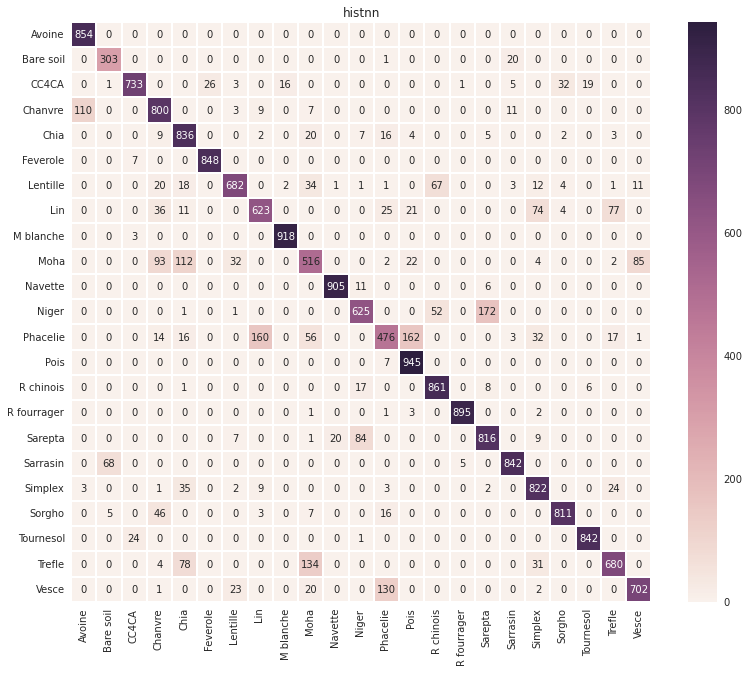

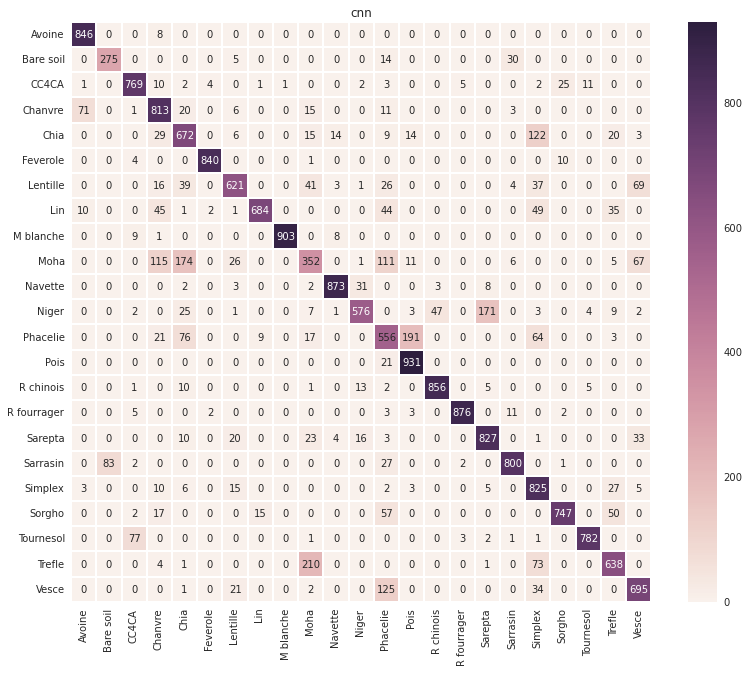

In [7]:
pl.figure(figsize=(13, 13))
pl.title('histnn')
confmat_hnn = skmetrics.confusion_matrix(y_test, y_test_pred_hnn, labels=np.arange(len(id2label)))
sns.heatmap(confmat_hnn, annot=True, fmt="d", xticklabels=id2label,
            square=True, cbar_kws={'shrink':0.8}, linewidths=1,
            yticklabels=id2label, vmin=0)

pl.figure(figsize=(13, 13))
pl.title('cnn')
confmat_cnn = skmetrics.confusion_matrix(y_test, y_test_pred_cnn, labels=np.arange(len(id2label)))
sns.heatmap(confmat_cnn, annot=True, fmt="d", xticklabels=id2label,
            square=True, cbar_kws={'shrink':0.8}, linewidths=1,
            yticklabels=id2label, vmin=0)

<matplotlib.colorbar.Colorbar instance at 0x7f43186bc7e8>

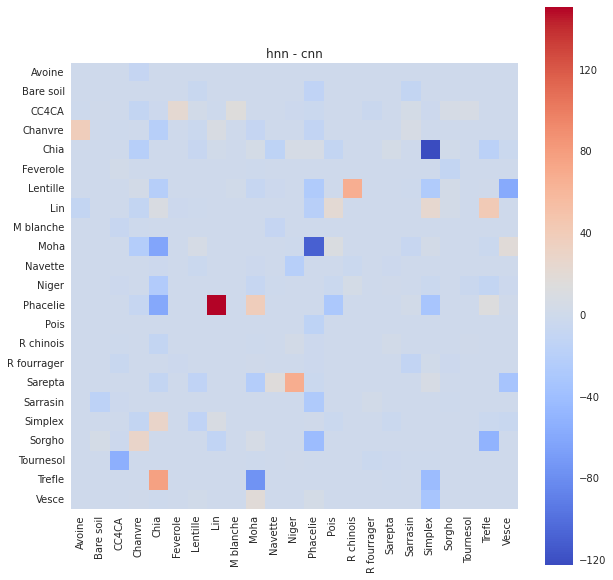

In [8]:
# confmat differences, only meaningfull for off-diagonal entries
confmat_diff = confmat_hnn - confmat_cnn
np.fill_diagonal(confmat_diff, 0)

pl.figure(figsize=(10, 10))
pl.title('hnn - cnn')
pl.imshow(confmat_diff, interpolation='nearest', cmap=cm.coolwarm)
pl.grid('off')
pl.xticks(np.arange(len(id2label)), id2label, rotation='vertical')
pl.yticks(np.arange(len(id2label)), id2label)
pl.colorbar()

We see there are some points that are Lin but wrongly classified as Trefle. Let's find them.

In [9]:
lid1 = np.flatnonzero(id2label == 'Lin')[0]
#lid2 = np.flatnonzero(id2label == 'Trefle')[0]
lid2 = np.flatnonzero(id2label == 'Simplex')[0]
#lid1 = np.flatnonzero(id2label == 'Phacelie')[0]
#lid2 = np.flatnonzero(id2label == 'Pois')[0]
print lid1
print lid2

7
18


In [10]:
# We want lid1 points that were wrongly classified by the histnn but correctly by the cnn
indices1 = np.flatnonzero(
    np.logical_and(
        np.logical_and(
            y_test == lid1,
            y_test_pred_hnn == lid2,
        ),
        y_test_pred_cnn == lid1
    )
)
# correct reference (lid2) points
indices2 = np.flatnonzero(
    np.logical_and(
        y_test == lid2,
        y_test_pred_hnn == lid2
    )
)
print len(indices1)
print len(indices2)

54
822


(54, 60)
(822, 60)
29 154


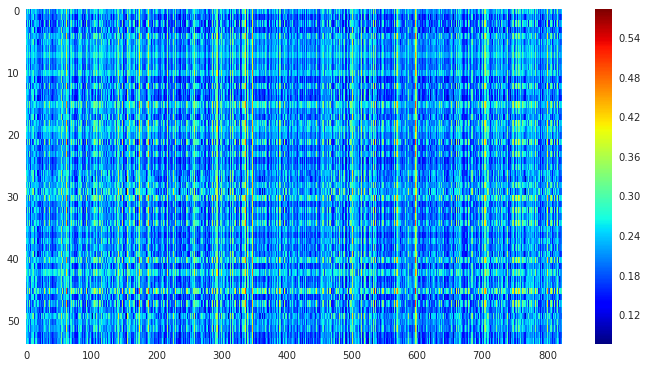

In [11]:
# amongst the lin points that are wrongly classified as simplex by the histnn
# but correctly as lin by the cnn, find the two with the closest histograms
import sklearn.metrics.pairwise as skdists

hists1 = get_hist(test_ij[indices1]).reshape(-1, 60)
hists2 = get_hist(test_ij[indices2]).reshape(-1, 60)
print hists1.shape
print hists2.shape

D = skdists.pairwise_distances(hists1, hists2)

pl.figure(figsize=(12, 6))
pl.imshow(D, interpolation='nearest', aspect='auto', cmap=cm.jet)
pl.grid('off')
pl.colorbar()

i1, i2 = np.unravel_index(D.argmin(), D.shape)
print i1, i2

In [13]:
def plot_hist(H, ax=None):
    if ax is None:
        ax = pl.gca()
    i = 0
    for chan, color in zip(range(3), ['r', 'g', 'b']):
        ax.bar(np.arange(20) + 0.5, H[chan],
               width=0.5, color=color, alpha=0.5)
        i += 20
    ax.grid('off')
        
def plot_win(win, ax=None):
    if ax is None:
        ax = pl.gca()
    ax.imshow(win.transpose(1, 2, 0), interpolation='nearest')
    ax.grid('off')
    ax.axis('off')

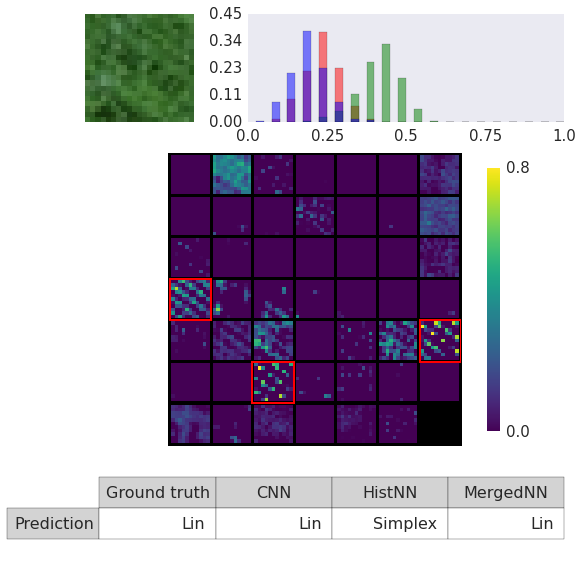

In [41]:
import matplotlib
from matplotlib.patches import Rectangle

hist_ylim = (0, 0.45)
conv_vmax = 0.8

nbins = (20)
binranges = [(0, 1), (0, 1), (0, 1)]

matplotlib.rcParams.update({
    'font.size': 20,
    'axes.titlesize' : 18,
    'xtick.labelsize' : 15,
    'ytick.labelsize' : 15
})

def analyze_point(test_index):
    """Show a nice plot to understand CNN and histnn behavior for a given point"""
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    # forward through the model and get intermediate states
    ij = test_ij[test_index].reshape(1, 2)
    y_true = y_test[test_index]
    convout = np.squeeze(apply_conv(ij))
    winout = np.squeeze(get_win(ij))
    histout = np.squeeze(get_hist(ij))
    cnn_pred = get_pred_cnn(ij)
    hnn_pred = get_pred_hnn(ij)
    mnn_pred = get_pred_mnn(ij)
    
    #print '-- predictions :'
    #print 'true : ', id2label[y_true]
    #print 'cnn : ', id2label[np.argmax(cnn_pred, axis=1)].item()
    #print 'hnn : ', id2label[np.argmax(hnn_pred, axis=1)].item()
    #print 'mnn : ', id2label[np.argmax(mnn_pred, axis=1)].item()
    
    #cmap = copy.deepcopy(cm.binary)
    cmap = copy.deepcopy(agronn.colormaps.viridis)
    #cmap.set_bad('lightgray')
    #cmap = sns.blend_palette(sns.cubehelix_palette(8), n_colors=8, as_cmap=True)
    cmap.set_bad('k')
    #cmap.set_bad((145/255., 85/255., 132/255.))
    #cmap.set_bad((102/255., 50/255., 0))

    ax1 = pl.subplot2grid((12,8), (0,0), rowspan=3, colspan=3)
    #ax1.set_title('Input window')
    # add 0.5 because it was centered
    plot_win(0.5 + winout, ax=ax1)

    ax2 = pl.subplot2grid((12,8), (0,3), rowspan=3, colspan=5)
    #ax2.set_title('RGB histogram')
    plot_hist(histout, ax=ax2)
    
    ax2.set_yticks(np.linspace(hist_ylim[0], hist_ylim[1], num=5))
    ax2.set_xticks(np.linspace(0, 20, num=5))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_xticklabels([str(f) for f in np.linspace(0, 1, num=5)])
    ax2.set_ylim(hist_ylim)

    ax3 = pl.subplot2grid((12,8), (3,0), rowspan=7, colspan=8)
    #ax3.set_title('Output of first convolution layer')
    plim = ax3.imshow(utils.pad_mosaic(utils.make_mosaic(convout, 7, 7), 1),
                      cmap=cmap, interpolation='nearest', vmax=conv_vmax)
    ax3.grid('off')
    ax3.axis('off')
    #cb = pl.colorbar(plim, shrink=0.9, ticks=[0, 0.2, 0.4, 0.6, 0.8])
    cb = pl.colorbar(plim, shrink=0.9, ticks=[0, 0.8])
    cb.solids.set_rasterized(True) 
    
    # red rect highlights
    ax3.add_patch(Rectangle((0, 36), 12, 12, facecolor="none", linewidth=2, edgecolor='red'))
    ax3.add_patch(Rectangle((24, 60), 12, 12, facecolor="none", linewidth=2, edgecolor='red'))
    ax3.add_patch(Rectangle((72.5, 48), 12, 12, facecolor="none", linewidth=2, edgecolor='red'))
    
    ax4 = pl.subplot2grid((12, 8), (10,0), rowspan=2, colspan=8)
    ax4.grid('off')
    ax4.axis('off')
    table = ax4.table(cellText=[[id2label[y_true],
                         id2label[np.argmax(cnn_pred, axis=1)].item(),
                         id2label[np.argmax(hnn_pred, axis=1)].item(),
                         id2label[np.argmax(mnn_pred, axis=1)].item()]],
              rowLabels=['Prediction'],
              colLabels=['Ground truth', 'CNN', 'HistNN', 'MergedNN'],
              rowColours=['lightgray'],
              colColours=['lightgray']*4,
              loc='upper center',
              bbox=(0.1, 0, 0.9, 1))
              #bbox=(0.3, 0.2, 0.5, 0.6))
              #bbox=(0.9, 0, 1.5, 1))
            
    table.auto_set_font_size(False)
    table.set_fontsize(16)
    #table.scale(1.5, 1.5)
    
    pl.tight_layout(w_pad=0, h_pad=0, pad=0.5)

pl.figure(figsize=(8, 8))
#analyze_point(refs[2])
analyze_point(indices1[i1])
pl.savefig('../../latex/figs/window_analysis_lin.pdf', dpi=150, bbox_inches='tight')

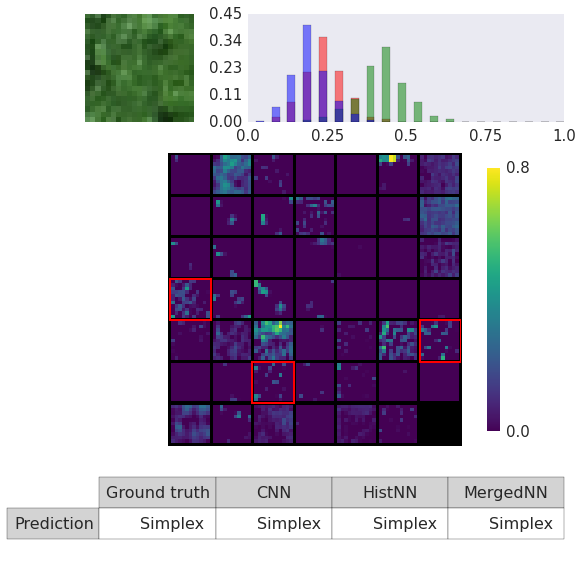

In [42]:
pl.figure(figsize=(8, 8))
analyze_point(indices2[i2])

pl.savefig('../../latex/figs/window_analysis_simplex.pdf', dpi=150, bbox_inches='tight')

# Analysis of weights difference between CNN and Merged

Merged is initialized with CNN's weights

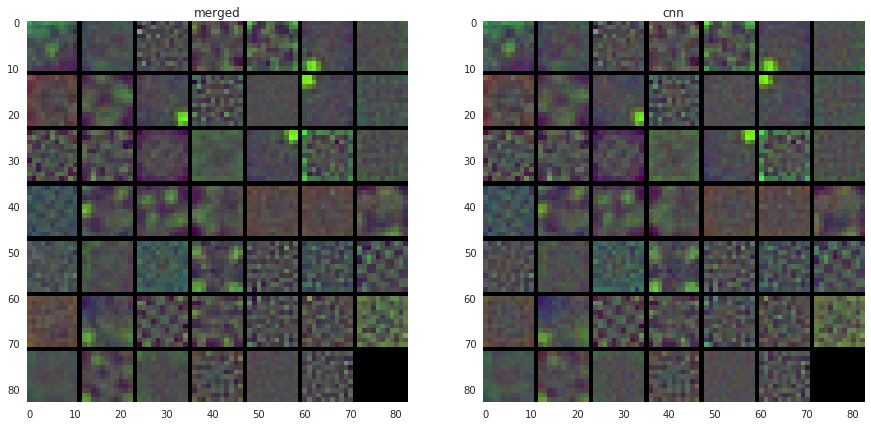

In [15]:
def get_wimg(model):
    convW, convb = model.nodes['cnn'].nodes['conv1'].get_weights()
    wimg = utils.make_mosaic_rgb(convW.transpose(0, 2, 3, 1), 7, 7)
    wimg[~wimg.mask] = utils.norm01(wimg[~wimg.mask])
    wimg[wimg.mask] = 0
    return wimg
    
wimg_mnn = get_wimg(model_mnn)
wimg_cnn = get_wimg(model_cnn)

pl.figure(figsize=(15, 8))
pl.subplot(121)
pl.title('merged')
pl.imshow(wimg_mnn, interpolation='nearest')
pl.grid('off')
pl.subplot(122)
pl.title('cnn')
pl.imshow(wimg_cnn, interpolation='nearest')
pl.grid('off')

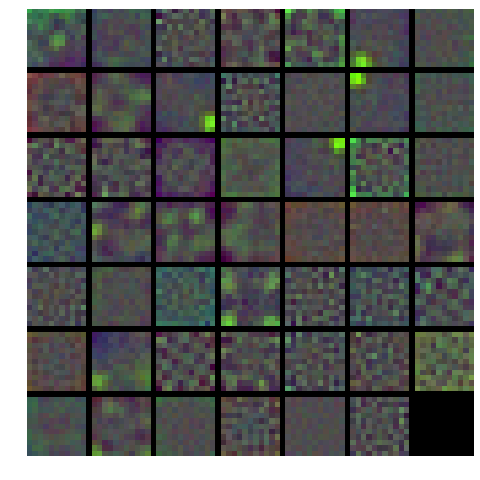

In [16]:
# Save the cnn weights
pl.figure(figsize=(8, 8))
#pl.title('CNN conv1 filters weights')
pl.imshow(wimg_cnn, interpolation='nearest')
pl.grid('off')
pl.axis('off')
pl.savefig('../../latex/figs/cnn_conv1_filter_weights.png', dpi=150, bbox_inches='tight')

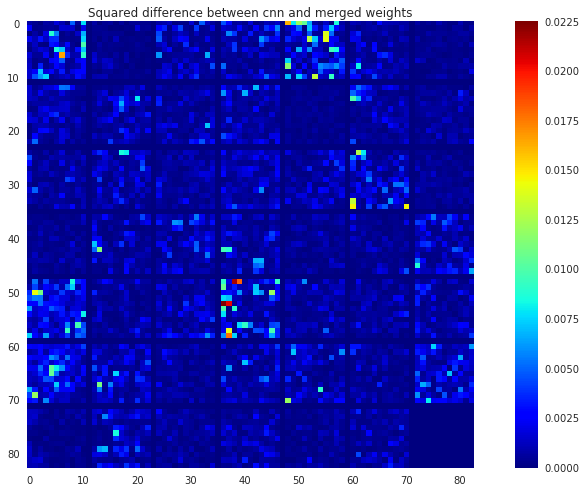

In [17]:
pl.figure(figsize=(15, 8))
pl.title(('Squared difference between cnn and merged weights'))
pl.imshow(np.sum((wimg_mnn - wimg_cnn)**2, axis=2), interpolation='nearest', cmap=cm.jet)
pl.grid('off')
pl.colorbar()

# Average sum of activation of each neuron, per class

In [18]:
act_avg = np.zeros((id2label.shape[0], 48), dtype=np.float)
act_std = np.zeros((id2label.shape[0], 48), dtype=np.float)
for lid, lname in enumerate(id2label):
    ijs = test_ij[np.logical_and(y_test == lid, y_test_pred_cnn == lid)]
    convout = np.squeeze(apply_conv(ijs))
    #print np.mean(convout, axis=0).shape
    #neuron_sum_avg = np.std(convout, axis=0).sum(axis=2).sum(axis=1)
    act_avg[lid] = np.mean(convout.reshape(convout.shape[0], convout.shape[1], -1), axis=2).mean(axis=0)
    act_std[lid] = np.std(convout.reshape(convout.shape[0], convout.shape[1], -1), axis=2).mean(axis=0)

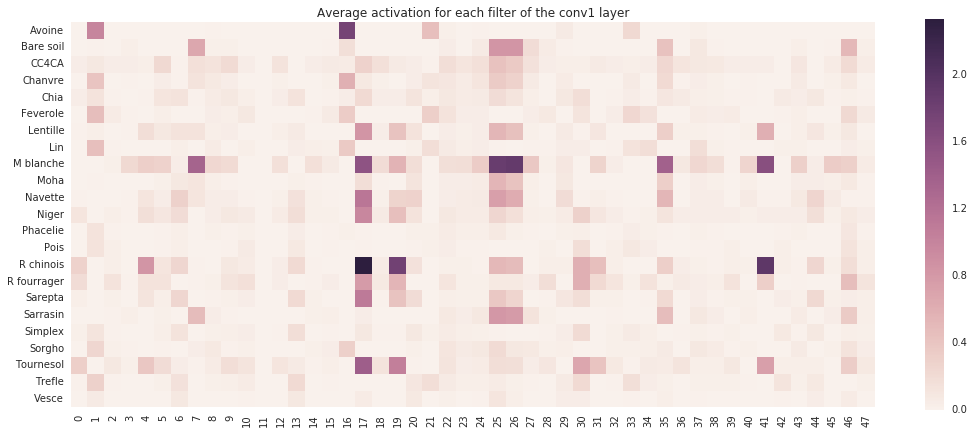

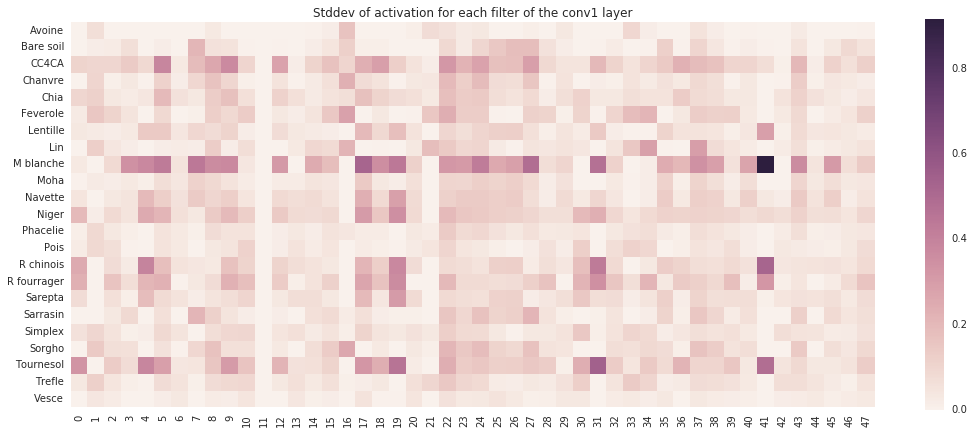

In [19]:
pl.figure(figsize=(18, 7))
pl.title('Average activation for each filter of the conv1 layer')
ax = sns.heatmap(act_avg, annot=False, fmt=".2f", xticklabels=np.arange(48),
                 yticklabels=id2label, linewidths=0, square=True, 
                 rasterized=True)
_ = pl.xticks(rotation=90)
pl.savefig('../../latex/figs/cnn_conv1_avg_act.png', dpi=150, bbox_inches='tight')

pl.figure(figsize=(18, 7))
pl.title('Stddev of activation for each filter of the conv1 layer')
ax = sns.heatmap(act_std, annot=False, fmt=".2f", xticklabels=np.arange(48),
                 yticklabels=id2label, linewidths=0, square=True, 
                 rasterized=True)
_ = pl.xticks(rotation=90)
pl.savefig('../../latex/figs/cnn_conv1_std_act.png', dpi=150, bbox_inches='tight')

# Average per-class activation

In [20]:
lid1 = np.flatnonzero(id2label == 'Lin')[0]
lid2 = np.flatnonzero(id2label == 'Simplex')[0]
print lid1
print lid2

7
18


In [21]:
# points that are correctly predicted as Lin
idx_lin = np.flatnonzero(
    np.logical_and(
        y_test == lid1,
        y_test_pred_cnn == lid1,
    )
)
# same for simplex
idx_simplex = np.flatnonzero(
    np.logical_and(
        y_test == lid2,
        y_test_pred_cnn == lid2,
    )
)
print len(idx_lin)
print len(idx_simplex)

ij_lin = test_ij[idx_lin]
ij_simplex = test_ij[idx_simplex]

684
825


In [22]:
convout_lin = np.squeeze(apply_conv(ij_lin))
cnn_pred_lin = get_pred_cnn(ij_lin)
convout_simplex = np.squeeze(apply_conv(ij_simplex))
cnn_pred_simplex = get_pred_cnn(ij_simplex)

In [23]:
print np.unique(np.argmax(cnn_pred_lin, axis=1))
print np.unique(np.argmax(cnn_pred_simplex, axis=1))

[7]
[18]


In [24]:
conv_mean_lin = np.mean(convout_lin, axis=0)
conv_mean_simplex = np.mean(convout_simplex, axis=0)

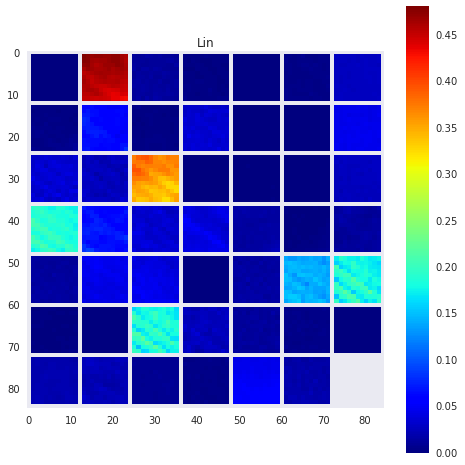

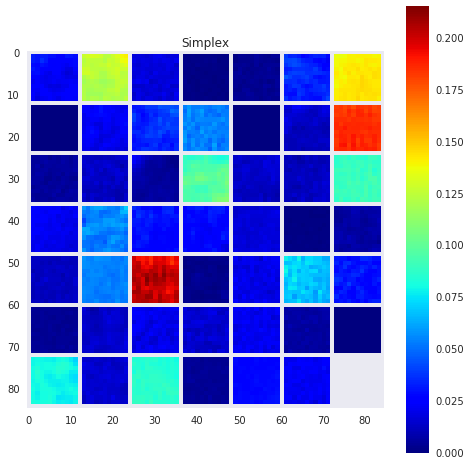

In [25]:
def norm_per_filter(convout):
    """
    Given a convout, min-max normalize each filter (square) between 0 and 1
    """
    nmin = convout.min(axis=2).min(axis=1)[:,None,None]
    nmax = convout.max(axis=2).max(axis=1)[:,None,None]
    return (convout - nmin) / (nmax - nmin)

pl.figure(figsize=(8, 8))
pl.title('Lin')
#pl.imshow(utils.pad_mosaic(utils.make_mosaic(norm_per_filter(conv_mean_lin), 7, 7), 1),
#          cmap=cm.jet, interpolation='nearest',)
pl.imshow(utils.pad_mosaic(utils.make_mosaic(conv_mean_lin, 7, 7), 1),
          cmap=cm.jet, interpolation='nearest')
pl.grid('off')
pl.colorbar()

pl.figure(figsize=(8, 8))
pl.title('Simplex')
#pl.imshow(utils.pad_mosaic(utils.make_mosaic(norm_per_filter(conv_mean_simplex), 7, 7), 1),
#          cmap=cm.jet, interpolation='nearest',)
pl.imshow(utils.pad_mosaic(utils.make_mosaic(conv_mean_simplex, 7, 7), 1),
          cmap=cm.jet, interpolation='nearest')
pl.grid('off')
pl.colorbar()

In [26]:
# We can make a boxplot of the total activation of a given filter to see if it's a good linear separator
# between our two classes.
if False:
    sum_act_lin = convout_lin[:,32].sum(axis=2).sum(axis=1)
    sum_act_simplex = convout_simplex[:,32].sum(axis=2).sum(axis=1)

    _ = pl.boxplot([sum_act_lin, sum_act_simplex], notch=True)